In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
file_path = '/content/drive/My Drive/Cibil/Master_Loan_Summary.csv'

In [4]:
df = pd.read_csv(file_path)

<ipython-input-4-47c250c455f0>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [5]:
df.head()

,loan_number,amount_borrowed,term,borrower_rate,installment,grade,origination_date,listing_title,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,last_payment_date,next_payment_due_date,days_past_due,loan_status_description,data_source
0,10149342,27050.0,36,0.1099,885.46,B,2013-12-01T00:00,debt_consolidation,0.0,27050.0,4702.53,0.0,0.0,2016-07-01T00:00,2016-08-01T00:00,0,COMPLETED,Lending Club
1,10149488,4800.0,36,0.1099,157.13,B,2013-12-01T00:00,home_improvement,0.0,4800.0,357.52,0.0,0.0,2014-09-01T00:00,2014-10-01T00:00,0,COMPLETED,Lending Club
2,10148122,12000.0,36,0.0762,373.94,A,2013-12-01T00:00,debt_consolidation,0.0,12000.0,1397.54,0.0,0.0,2016-06-01T00:00,2016-07-01T00:00,0,COMPLETED,Lending Club
3,10119623,12000.0,36,0.1199,398.52,B,2013-12-01T00:00,debt_consolidation,0.0,12000.0,2346.48,0.0,0.0,2017-01-01T00:00,2017-02-01T00:00,0,COMPLETED,Lending Club
4,10159498,12000.0,36,0.0662,368.45,A,2013-12-01T00:00,debt_consolidation,0.0,12000.0,1263.95,0.0,0.0,2017-01-01T00:00,2017-02-01T00:00,0,COMPLETED,Lending Club


In [6]:
df = df.dropna() #removes rows with missing values from the dataframe

In [7]:
df['origination_date'] = pd.to_datetime(df['origination_date'], errors='coerce', utc=True) #convert orgination date to datetime object
df['last_payment_date'] = pd.to_datetime(df['last_payment_date'], errors='coerce', utc=True)
df['loan_age'] = (df['last_payment_date'] - df['origination_date']).dt.days / 365 # Calculates the loan age in years by subtracting origination date from last payment date.

In [8]:
X = df[['amount_borrowed', 'term', 'borrower_rate', 'installment', 'principal_balance',
        'principal_paid', 'interest_paid', 'late_fees_paid', 'debt_sale_proceeds_received',
        'days_past_due', 'loan_age', 'listing_title', 'data_source']] #independent variable

y = df['grade'] #dependent variable

In [9]:
numerical_features = ['amount_borrowed', 'term', 'borrower_rate', 'installment', 'principal_balance',
                      'principal_paid', 'interest_paid', 'late_fees_paid', 'debt_sale_proceeds_received', 'days_past_due', 'loan_age']


In [10]:
categorical_features = ['listing_title', 'data_source']

In [11]:
numerical_transformer = StandardScaler() #Scales numerical features to have zero mean and unit variance
categorical_transformer = OneHotEncoder() #Converts categorical features into numerical representations using one-hot encoding.

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
]) #Creates a pipeline that first preprocesses the data and then applies the RandomForestClassifier for classification.


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount_borrowed', 'term',
                                                   'borrower_rate',
                                                   'installment',
                                                   'principal_balance',
                                                   'principal_paid',
                                                   'interest_paid',
                                                   'late_fees_paid',
                                                   'debt_sale_proceeds_received',
                                                   'days_past_due',
                                                   'loan_age']),
                                                 ('cat', OneHotEncoder(),
                                                  ['listing_title',
                                                   'data_source'])])),
                ('classifier', RandomForestClassifier())])

In [15]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       1.00      0.99      0.99     70267
           B       0.98      0.98      0.98    117288
           C       0.97      0.97      0.97    117942
           D       0.94      0.95      0.94     59499
           E       0.91      0.90      0.91     25987
           F       0.90      0.89      0.90      8788
           G       0.95      0.84      0.89      2643

    accuracy                           0.97    402414
   macro avg       0.95      0.93      0.94    402414
weighted avg       0.97      0.97      0.97    402414



In [16]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)

In [17]:
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9674


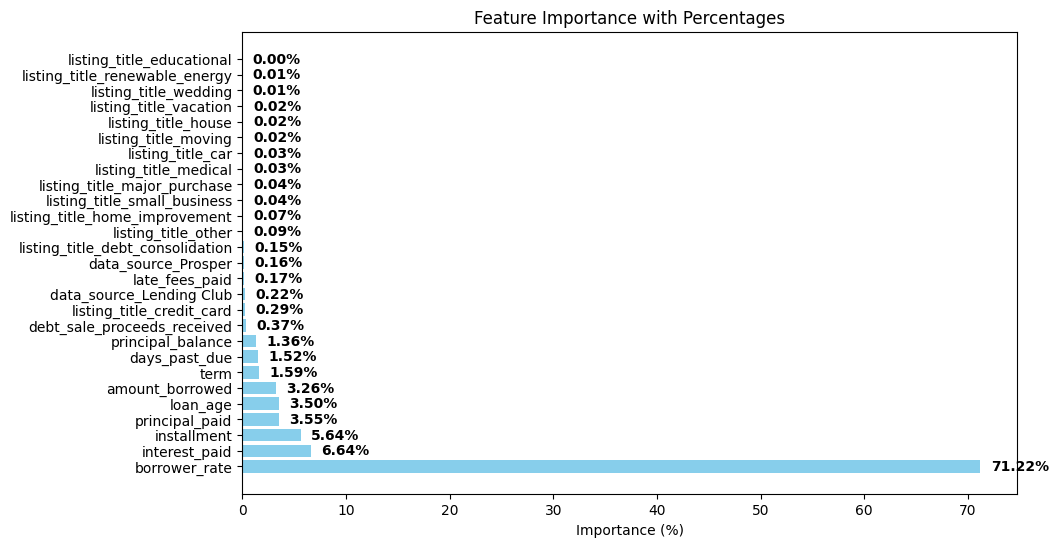

In [18]:
import matplotlib.pyplot as plt
import numpy as np

importances = model.named_steps['classifier'].feature_importances_

feature_names = numerical_features + list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))

indices = np.argsort(importances)[::-1] #In decending order returns the indices that would sort the importances

importances_percentage = importances[indices] / np.sum(importances) * 100

plt.figure(figsize=(10, 6))
plt.title("Feature Importance with Percentages")
plt.barh(range(len(importances)), importances_percentage, align='center', color='skyblue')
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel("Importance (%)")

for i, v in enumerate(importances_percentage):
    plt.text(v + 1, i, f"{v:.2f}%", va='center', fontweight='bold')

plt.show()


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [20]:
selected_features = ['borrower_rate', 'interest_paid', 'installment', 'term', 'principal_paid', 'amount_borrowed', 'loan_age']

X_ = df[selected_features]
y_ = df['grade']

In [21]:
scaler_ = StandardScaler()
X_scaled_ = scaler_.fit_transform(X_)

In [22]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_scaled_, y_, test_size=0.2, random_state=42)


In [23]:
model_ = RandomForestClassifier(random_state=42)
model_.fit(X_train_, y_train_)

RandomForestClassifier(random_state=42)

In [24]:
y_pred_ = model_.predict(X_test_)

In [25]:
accuracy_ = accuracy_score(y_test_, y_pred_)
print(f"Model Accuracy: {accuracy_:.4f}")

Model Accuracy: 0.9636


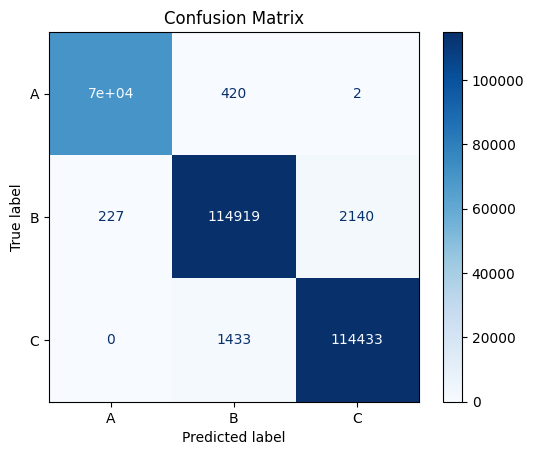

In [26]:
cm = confusion_matrix(y_test_, y_pred_, labels=['A', 'B', 'C'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B', 'C'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

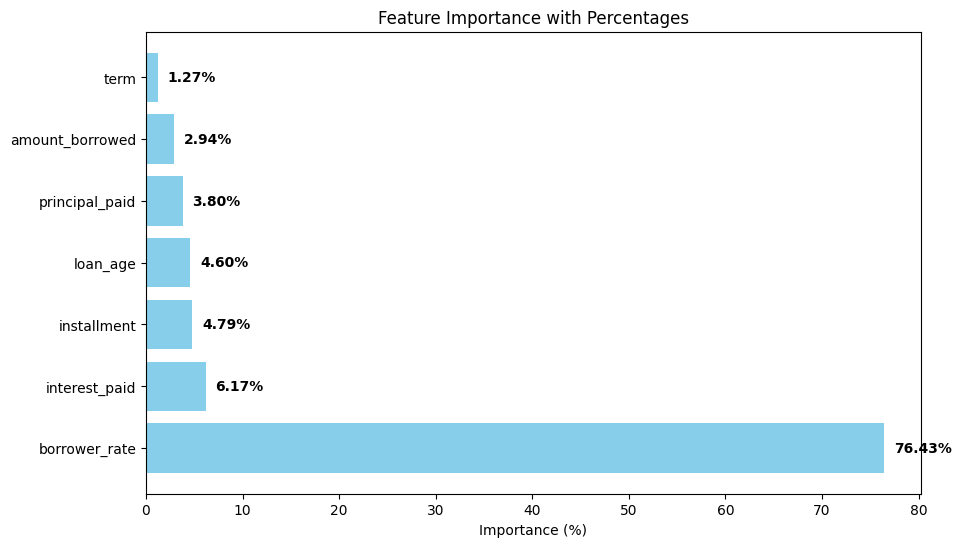

In [27]:
importances = model_.feature_importances_

indices = np.argsort(importances)[::-1]

importances_percentage = importances[indices] / np.sum(importances) * 100

plt.figure(figsize=(10, 6))
plt.title("Feature Importance with Percentages")
plt.barh(range(len(importances)), importances_percentage, align='center', color='skyblue')
plt.yticks(range(len(importances)), [selected_features[i] for i in indices])
plt.xlabel("Importance (%)")

for i, v in enumerate(importances_percentage):
    plt.text(v + 1, i, f"{v:.2f}%", va='center', fontweight='bold')

plt.show()

In [28]:
from sklearn.model_selection import cross_val_score

# Cross-validation with Random Forest
cv_scores = cross_val_score(model_, X_scaled_, y_, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

Cross-validation scores: [0.69735397 0.81409693 0.8502562  0.91946334 0.86526032]
Mean cross-validation accuracy: 0.8293


In [29]:
import joblib

joblib.dump(model_, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [30]:
import joblib

joblib.dump(scaler_, 'scaler.joblib')

['scaler.joblib']

In [31]:
import joblib
import numpy as np
from datetime import datetime

model = joblib.load('random_forest_model.joblib')
scaler = joblib.load('scaler.joblib')

def grade_to_label(grade):
    if grade == 'A':
        return 'Low'
    elif grade == 'B':
        return 'Medium'
    elif grade == 'C':
        return 'High'
    else:
        return 'Unknown'

def predict_grade():
    print("Enter the features for the loan:")

    borrower_rate = float(input("Enter borrower rate (e.g., 0.1099): "))
    interest_paid = float(input("Enter interest paid (e.g., 4702.53): "))
    installment = float(input("Enter installment (e.g., 885.46): "))
    term = int(input("Enter term (e.g., 36): "))
    principal_paid = float(input("Enter principal paid (e.g., 4702.53): "))
    amount_borrowed = float(input("Enter amount borrowed (e.g., 27050): "))

    origination_date_str = input("Enter origination date (YYYY-MM-DD): ")
    last_payment_date_str = input("Enter last payment date (YYYY-MM-DD): ")

    origination_date = datetime.strptime(origination_date_str, "%Y-%m-%d")
    last_payment_date = datetime.strptime(last_payment_date_str, "%Y-%m-%d")

    loan_age = (last_payment_date - origination_date).days / 365

    print(f"\nCalculated loan age: {loan_age} years")

    input_data = np.array([[borrower_rate, interest_paid, installment, term, principal_paid, amount_borrowed, loan_age]])

    input_data_scaled = scaler.transform(input_data)

    prediction = model.predict(input_data_scaled)

    grade_label = grade_to_label(prediction[0])

    print(f"\nPredicted Grade: {prediction[0]} ({grade_label})")

if __name__ == "__main__":
    predict_grade()


Enter the features for the loan:
Enter borrower rate (e.g., 0.1099): 0.0762
Enter interest paid (e.g., 4702.53): 1397.54
Enter installment (e.g., 885.46): 885.46
Enter term (e.g., 36): 36
Enter principal paid (e.g., 4702.53): 12000
Enter amount borrowed (e.g., 27050): 12000
Enter origination date (YYYY-MM-DD): 2013-12-01
Enter last payment date (YYYY-MM-DD): 2016-06-01

Calculated loan age: 2.5013698630136987 years

Predicted Grade: A (Low)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
